In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from dreamz.cppn import get_xy_mesh, CPPNNet, UpsampleNet
from torch import optim
from dreamz.render import train_visualiser
from dreamz.torch_layers import Lambda
from torch import nn
from torchvision import datasets, models, transforms

In [7]:
device = 'cpu'

In [101]:
if 1:
    model = models.resnet18(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-4] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
else:
    model = models.vgg11_bn(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-1] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
model = model.eval()

In [180]:
from dreamz.googlenet import googlenet

In [182]:
def get_imagenet_model():
    model = googlenet(pretrained=True)
    return model.eval()

model = get_imagenet_model()

In [218]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [217]:
list(model.children())[:12]

[BasicConv2d(
   (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True),
 BasicConv2d(
   (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 BasicConv2d(
   (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True),
 Inception(
   (branch1): BasicConv2d(
     (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   )
   (branch2): Sequential(
     (0): BasicConv2d(
       (conv): 

In [202]:
import torch
mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

In [203]:
from dreamz.utils import display_tch_im

In [204]:
widths = [24] * 8
base = CPPNNet(widths, output_channels=widths[-1])
viz = UpsampleNet(base, reps=1).to(device)

In [205]:
mask0 = torch.zeros([228, 406])
mask1 = torch.zeros([228, 406])
mask0[:, :406 // 2] = 1
mask1[:, 406 // 2:] = 1
masks = [mask0, mask1]
for m in masks:
    m.requires_grad = False

In [206]:
def get_cropped_mask(m, st_masks):
    out = []
    for st in st_masks:
        out.append(m.unsqueeze(0)[:, :, st:st + 228])
    out = torch.stack(out)
    return out

In [207]:
def imgnet_objective(output, st_masks, masks=masks, cs=[25, 45]):
    loss = None
    this_masks = [get_cropped_mask(m, st_masks) for m in masks]
    for m, c in zip(this_masks, cs):
        to_model = ((output - mean) / std)
        to_model *= m
        r = model(to_model)
        this_loss = -r[:, c].mean()
        if loss is None:
            loss = this_loss
        else:
            loss += this_loss
#     return torch.mean((r - targ) ** 2)
    return loss

size = [59, 105]
xy = get_xy_mesh(size).to(device)
def im_gen_fn(pct_done=0.0, num=4):
    xy_crop = []
    st_masks = []
    for i in range(num):
        x0 = np.random.randint(0, 105 - 59)
        st_masks.append(int(x0 * 228 / 59))
        xy_crop.append(xy[:, :, :, x0:x0 + 59])
    xy_crop = torch.cat(xy_crop, 0)
    return viz(xy_crop), st_masks

In [208]:
opt = optim.Adam(viz.parameters(), lr=0.002)
div = 10

  0%|          | 0/150 [00:00<?, ?it/s]

cost -0.44403478503227234


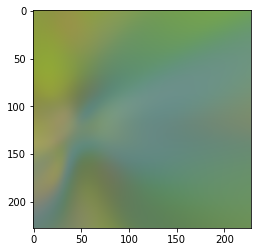

  3%|▎         | 5/150 [00:04<02:14,  1.08it/s]

cost -0.8559221029281616


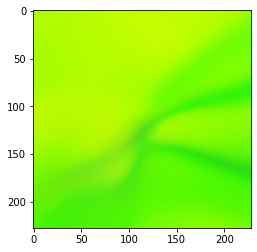

  7%|▋         | 10/150 [00:08<01:57,  1.19it/s]

cost -0.8437231779098511


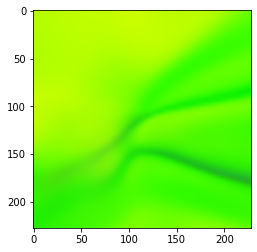

 10%|█         | 15/150 [00:12<01:43,  1.30it/s]

cost -0.7804421186447144


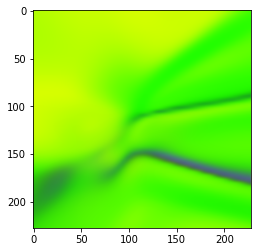

 13%|█▎        | 20/150 [00:15<01:32,  1.40it/s]

cost -1.2518887519836426


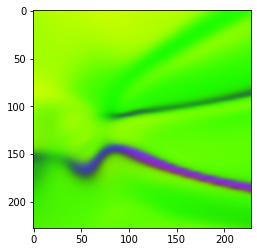

 17%|█▋        | 25/150 [00:19<01:31,  1.37it/s]

cost -1.1748123168945312


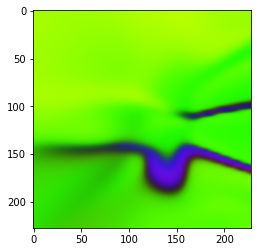

 20%|██        | 30/150 [00:23<01:25,  1.41it/s]

cost -1.530799150466919


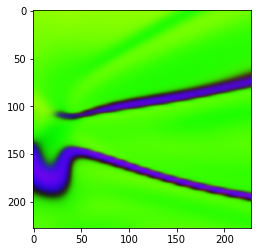

 23%|██▎       | 35/150 [00:26<01:17,  1.48it/s]

cost -1.5930280685424805


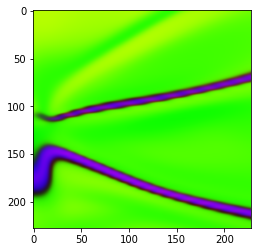

 27%|██▋       | 40/150 [00:30<01:15,  1.46it/s]

cost -1.715826392173767


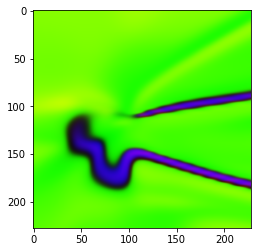

 30%|███       | 45/150 [00:33<01:08,  1.54it/s]

cost -1.767463207244873


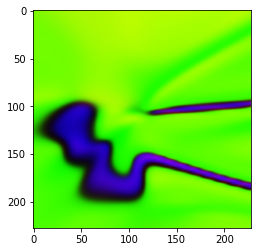

 33%|███▎      | 50/150 [00:37<01:10,  1.43it/s]

cost -1.8387330770492554


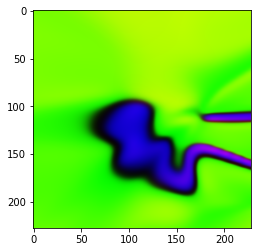

 37%|███▋      | 55/150 [00:41<01:09,  1.37it/s]

cost -1.8890442848205566


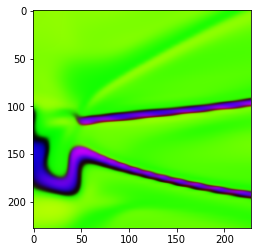

 40%|████      | 60/150 [00:45<01:08,  1.32it/s]

cost -1.9587339162826538


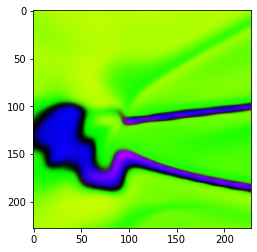

 43%|████▎     | 65/150 [00:48<01:03,  1.35it/s]

cost -2.129424810409546


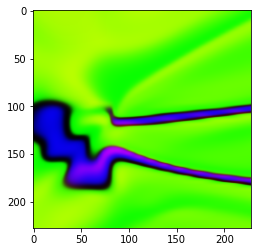

 47%|████▋     | 70/150 [00:52<00:57,  1.38it/s]

cost -1.8131134510040283


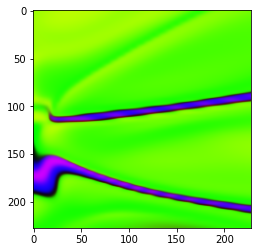

 50%|█████     | 75/150 [00:56<00:59,  1.25it/s]

cost -1.8911805152893066


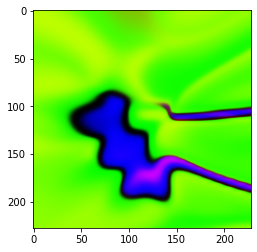

 53%|█████▎    | 80/150 [01:00<00:53,  1.32it/s]

cost -2.2754392623901367


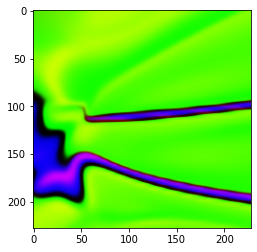

 57%|█████▋    | 85/150 [01:04<00:46,  1.39it/s]

cost -1.8735759258270264


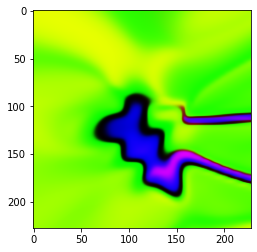

 60%|██████    | 90/150 [01:07<00:45,  1.33it/s]

cost -2.2280938625335693


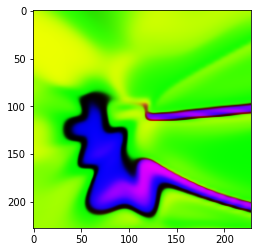

 63%|██████▎   | 95/150 [01:12<00:42,  1.29it/s]

cost -2.0485358238220215


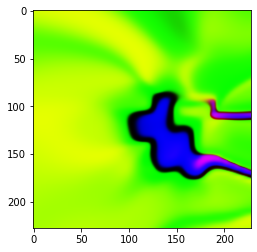

 67%|██████▋   | 100/150 [01:15<00:36,  1.36it/s]

cost -2.1625747680664062


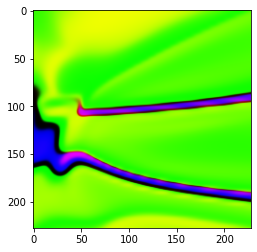

 70%|███████   | 105/150 [01:19<00:34,  1.30it/s]

cost -2.157641649246216


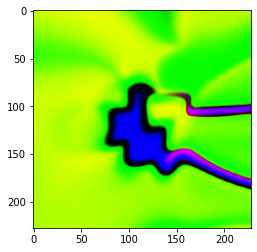

 73%|███████▎  | 110/150 [01:23<00:32,  1.25it/s]

cost -2.0265250205993652


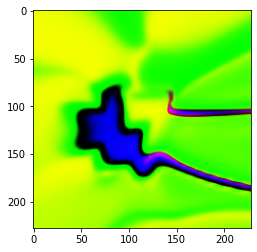

 77%|███████▋  | 115/150 [01:27<00:28,  1.21it/s]

cost -2.213848114013672


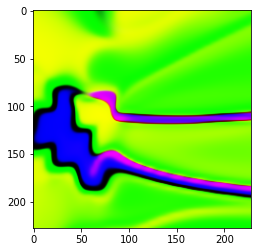

 80%|████████  | 120/150 [01:32<00:23,  1.26it/s]

cost -2.3710739612579346


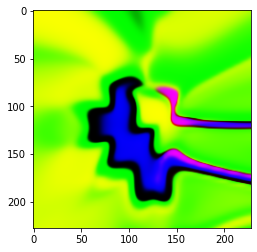

 83%|████████▎ | 125/150 [01:36<00:20,  1.22it/s]

cost -2.4673166275024414


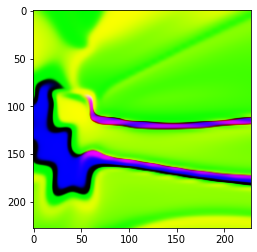

 87%|████████▋ | 130/150 [01:39<00:15,  1.31it/s]

cost -2.449618339538574


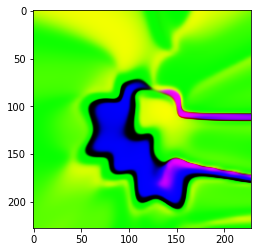

 90%|█████████ | 135/150 [01:44<00:12,  1.20it/s]

cost -2.586545944213867


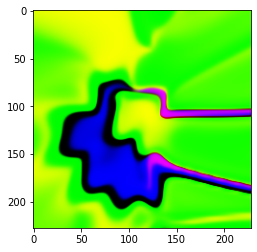

 93%|█████████▎| 140/150 [01:48<00:08,  1.22it/s]

cost -2.5333049297332764


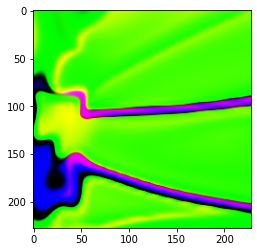

 97%|█████████▋| 145/150 [01:52<00:03,  1.30it/s]

cost -2.5066957473754883


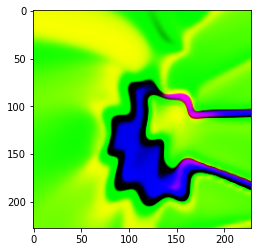

100%|██████████| 150/150 [01:56<00:00,  1.29it/s]


In [209]:
train_visualiser(imgnet_objective, im_gen_fn, opt, iters=30*50//div, log_interval=50//div)

In [210]:
xy_big = get_xy_mesh([277, 502]).to(device)

In [211]:
res = viz(xy_big)

In [212]:
# %timeit viz(xy_big)

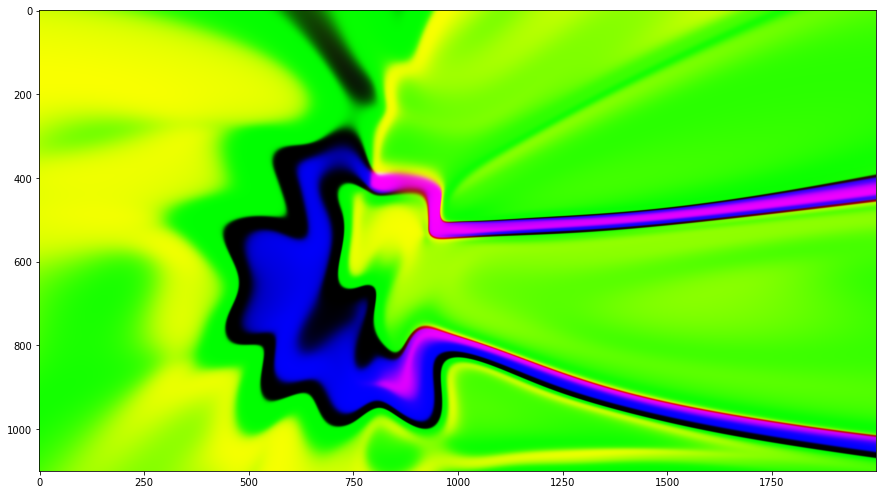

In [213]:
from dreamz.utils import display_tch_im
plt.figure(figsize=[15]*2)
display_tch_im(res)